### Import libraries

In [1]:
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import sklearn
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import seaborn as sns
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2

In [2]:
# Set file path
with_mask_dir = Path('../Assignment_2/FMD_DATASET/with_mask')
without_mask_dir = Path('../Assignment_2/FMD_DATASET/without_mask')


In [3]:
# Retrieve jpg file 
with_mask_dir.glob(r'*jpg')
without_mask_dir.glob(r'*jpg')

<generator object Path.glob at 0x00000159F3069930>

In [4]:
# Function to generate dataframe of file path and labels
def generate_df(image_path, label):
    filepath = pd.Series(list(image_path.glob(r'*jpg')), name = 'Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepath.index).astype(str)
    df = pd.concat([filepath, labels], axis=1)
    
    return df

In [5]:
# Generate dataframe and combine both dataframe into a single dataset
df_mask = generate_df(with_mask_dir,label = 1)
df_without_mask = generate_df(without_mask_dir, label = 0)

combined_df = pd.concat([df_mask, df_without_mask], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
combined_df.head()

,Filepath,Label
0,..\Assignment_2\FMD_DATASET\without_mask\simpl...,0
1,..\Assignment_2\FMD_DATASET\without_mask\simpl...,0
2,..\Assignment_2\FMD_DATASET\without_mask\simpl...,0
3,..\Assignment_2\FMD_DATASET\without_mask\simpl...,0
4,..\Assignment_2\FMD_DATASET\with_mask\simple39...,1


In [6]:
# split the dataset
combined_df.Label.value_counts(normalize=True)

train_df, test_df = train_test_split(combined_df, train_size=0.7, shuffle=True, random_state=1)

In [7]:
# Data augmentation
train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=.2,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# test on unseen data
test_gen = ImageDataGenerator(
    rescale = 1./255
)

def data_generator(aug_data,df,settype):
    data = aug_data.flow_from_dataframe(
        df,
        x_col='Filepath',
        y_col='Label',
        target_size=(120, 120),
        color_mode='rgb',
        class_mode='binary',
        batch_size=32,
        shuffle=True,
        seed=42,
        subset=settype
        )
    return data


In [8]:
# Perform data augmentation on train, val and test set
train_data = data_generator(train_gen,train_df,'training')
val_data = data_generator(train_gen,train_df,'validation')
test_data = test_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 4480 validated image filenames belonging to 2 classes.
Found 1120 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.


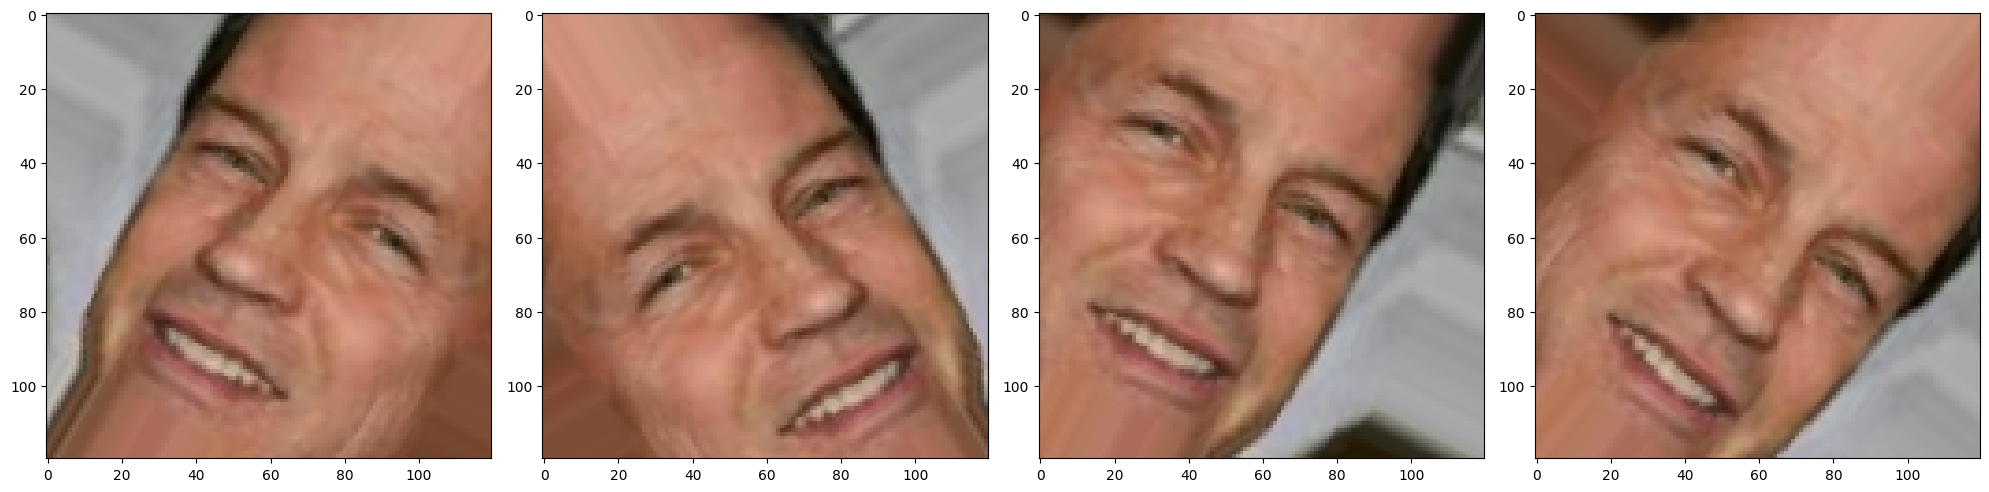

In [9]:
# Show augmented images
from IPython.display import Image

def plotImages(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_images = [train_data[0][0][0] for i in range(4)]
plotImages(augmented_images)

In [10]:
# Define model
model = Sequential()

# Input layer
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(120, 120, 3)))
model.add(MaxPooling2D(2, 2))

# 1st Covolutional Layer
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

# 2nd Layer
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

# 3rd Layer
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

# Fully connected layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 128)      0

In [11]:
# Compile model
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

In [19]:
# Train the model
history = model.fit(
    train_data,
    epochs=15,
    validation_data = val_data
)

C:\Users\USER-PC\anaconda3\envs\tf\lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5
140/140 [==============================] - 38s 271ms/step - loss: 0.0625 - accuracy: 0.9808 - val_loss: 0.0756 - val_accuracy: 0.9750
Epoch 2/5
140/140 [==============================] - 37s 262ms/step - loss: 0.0664 - accuracy: 0.9801 - val_loss: 0.0423 - val_accuracy: 0.9848
Epoch 3/5
140/140 [==============================] - 37s 262ms/step - loss: 0.0578 - accuracy: 0.9815 - val_loss: 0.0521 - val_accuracy: 0.9839
Epoch 4/5
140/140 [==============================] - 38s 268ms/step - loss: 0.0681 - accuracy: 0.9779 - val_loss: 0.0531 - val_accuracy: 0.9786
Epoch 5/5
140/140 [==============================] - 37s 262ms/step - loss: 0.0532 - accuracy: 0.9824 - val_loss: 0.0457 - val_accuracy: 0.9866


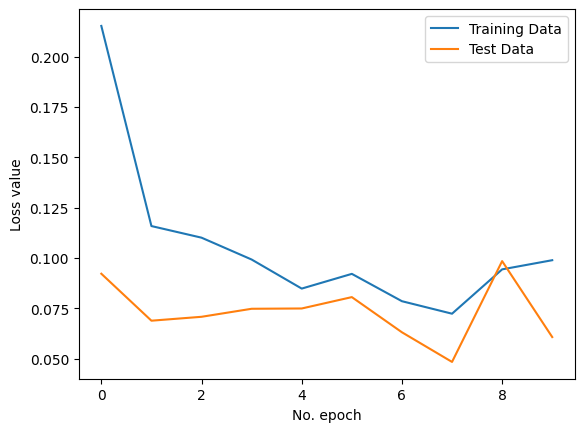

In [13]:
# Display graph of loss value vs epochs
plt.plot(history.history['loss'], label='Training Data')
plt.plot(history.history['val_loss'], label='Test Data')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

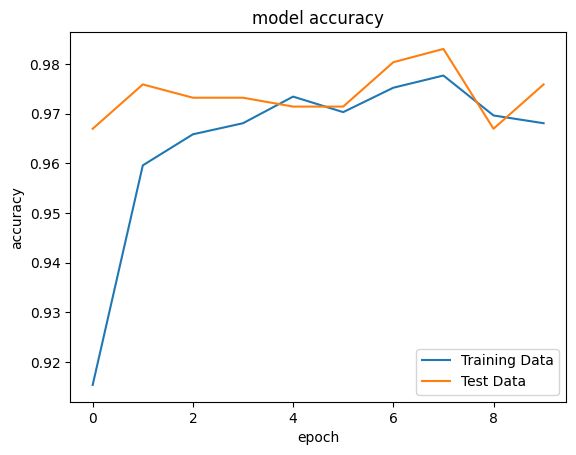

In [14]:
# Display graph accuracy vs epochs
plt.plot(history.history['accuracy'], label='Training Data')
plt.plot(history.history['val_accuracy'], label='Test Data')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

In [20]:
# Evaluate and display results
predictions = model.predict(test_data)
predicted_labels = np.round(predictions).astype(int)
true_labels = test_data.classes

cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

# Calculate metrics
cr = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1'])
print("Classification Report:", cr)

75/75 [==============================] - 9s 117ms/step
Confusion Matrix:
[[1192   10]
 [  20 1178]]
Classification Report:               precision    recall  f1-score   support

     Class 0       0.98      0.99      0.99      1202
     Class 1       0.99      0.98      0.99      1198

    accuracy                           0.99      2400
   macro avg       0.99      0.99      0.99      2400
weighted avg       0.99      0.99      0.99      2400



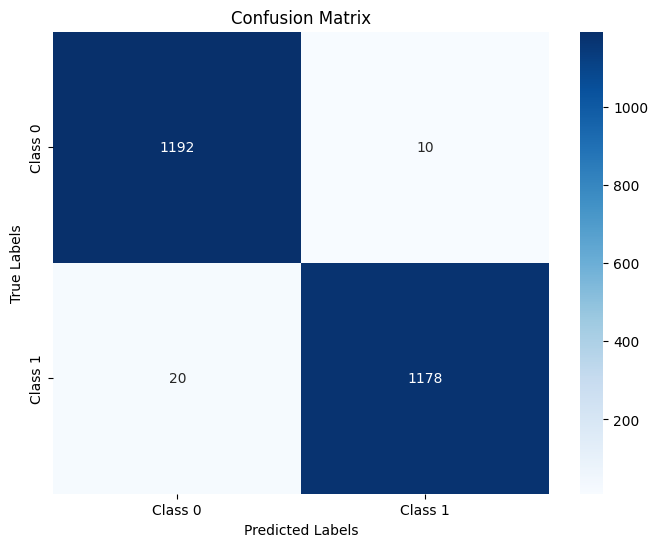

In [21]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Save the model
model.save('facemask_detection_model.h5')

## Prediction 

In [17]:
# Load the model (ensure you have the correct path to your model file)
model = tf.keras.models.load_model("facemask_detection_model.h5")

# Function to preprocess the input image
def preprocess_image(img_path, target_size=(120, 120)):
    img = cv2.imread(img_path)  # Load the JPEG image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR (OpenCV default) to RGB
    img = cv2.resize(img, target_size)  # Resize to model's input shape
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

# Function to predict the mask status and print probabilities
def predict_mask(img_path):
    img = preprocess_image(img_path)
    prediction = model.predict(img)
    print(f"Prediction probability: {prediction[0]}")  # Print the probability value
    result = "Mask" if prediction[0] > 0.5 else "No Mask"
    return result

In [18]:
# Test the model with an image
img_path = "../Assignment_2/FMD_DATASET/no_mask_kangkor/complex17.jpg"
result = predict_mask(img_path)
print(f"The predicted result is: {result}")

1/1 [==============================] - 0s 330ms/step
Prediction probability: [0.10322999]
The predicted result is: No Mask
